# Udacity Self-Driving Car Engineer Nanodegree Project 5

##  Vehicle Detection and Tracking

In this project, my goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4), and the main output or product I want to create is a detailed writeup of the project. 

The Project
---

The goals / steps of this project are the following, as the course mentioned. And I will implement all I studied about traditional computer vision algorithms to see the performances. **And most of the source codes are inspired by those functions in [udacity course resources](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/ea732214-fbc2-42b5-ad40-97a06a95b8ee). And I will do more in my further work.**

* Step1: Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Step2(optional): Apply a color transform and append spatial binned color features, as well as histograms of color, to combine the HOG feature vector.( Note: for those first two steps don't forget to normalize the features and randomize a selection for training and testing.)
* Step3: Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Step4: Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers(duplicate detections and false positives) and follow detected vehicles.
* Step5: Estimate a bounding box for vehicles detected.
* Step6: Write a good writeup_report.md.

### Loading useful packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Loading training data

In [2]:
# cannot put all the car/noncar images together because some of them have the same filename
car_examples = glob.glob('training_dataset/vehicles/**/*.png')
notcar_examples = glob.glob('training_dataset/non-vehicles/**/*.png')
print("Car examples:  {}".format(len(car_examples)))
print("Notcar examples:  {}".format(len(notcar_examples)))

Car examples:  8792
Notcar examples:  8968


### Training data exploration(visualization)

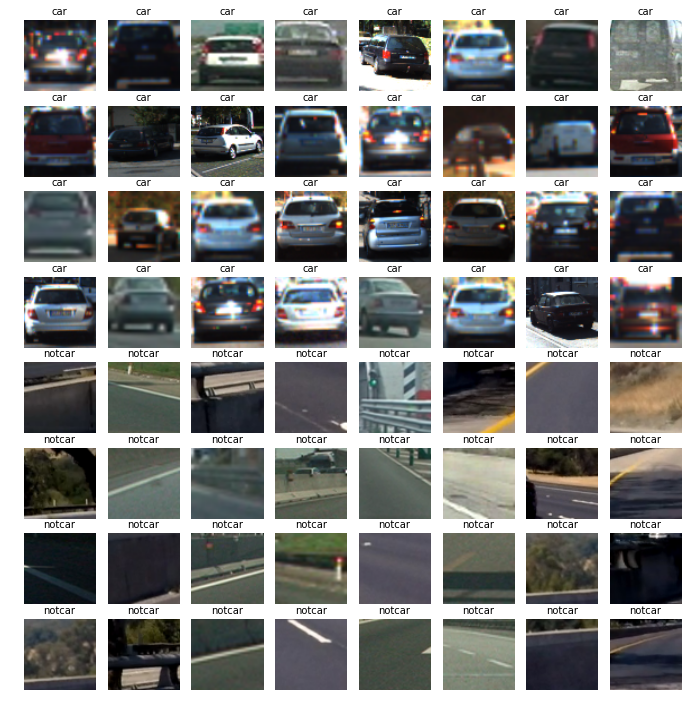

In [3]:
fig, axes = plt.subplots(8,8, figsize=(12, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()

# choose 32 examples from car_examples and notcar_examples, respectively
for i in np.arange(32):
    img = cv2.imread(car_examples[np.random.randint(0,len(car_examples))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].set_title('car', fontsize=10)
    axes[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(notcar_examples[np.random.randint(0,len(notcar_examples))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].set_title('notcar', fontsize=10)
    axes[i].imshow(img)
fig.savefig('output_images/example_visualization.jpg')

### Step1: Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.

- calcute the HOG features

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs hog_features and the hog_image if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
print('finished')

finished


Take a car example and a notcar example to see the HOG features, respectively.

finished


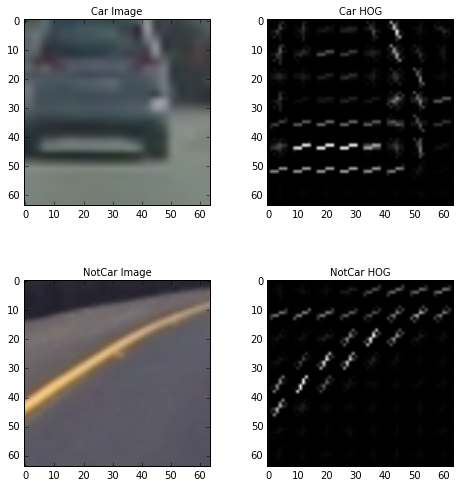

In [5]:
# fetch one example from positive and negative examples, respectively
car_img = mpimg.imread(car_examples[9])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

notcar_img = mpimg.imread(notcar_examples[9])
_, notcar_dst = get_hog_features(notcar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize the hog feature images
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(hspace = .4, wspace=.2)
axes[0][0].imshow(car_img)
axes[0][0].set_title('Car Image', fontsize=10)
axes[0][1].imshow(car_dst, cmap='gray')
axes[0][1].set_title('Car HOG', fontsize=10)
axes[1][0].imshow(notcar_img)
axes[1][0].set_title('NotCar Image', fontsize=10)
axes[1][1].imshow(notcar_dst, cmap='gray')
axes[1][1].set_title('NotCar HOG', fontsize=10)
fig.savefig('output_images/HOG.jpg')
print('finished')

### Step2(optional): Apply a color transform and append spatial binned color features, as well as histograms of color, to combine the HOG feature vector.( Note: for those first two steps don't forget to normalize the features and randomize a selection for training and testing.)
- Extracting HOG and various colorspace features from car example and notcar example arrays

In [6]:
# Define a function to extract features from a list of image locations

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    '''
    # This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
    # flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
    # to be used together for classification
    '''
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

print('finished')

finished


### Step2(optional): Apply a color transform and append spatial binned color features, as well as histograms of color, to combine the HOG feature vector.( Note: for those first two steps don't forget to normalize the features and randomize a selection for training and testing.)
- Data processing: Extracting the combined features about YUV colorspace and shape from car/notcar example dataset. Then do data normalization, randomization and train/validation split.

In [7]:
# Define feature extraction parameters, respectively
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# define the timer to calculate computional time
t = time.time()
car_features = extract_features(car_examples, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcar_examples, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and validation sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

63.2 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


#### **My notes:**
The dataset normalization will be necessary if combining different types of features such as HOG and color_hist with bin_spatial features. However, in this project only the HOG and YUV colorspace are used. So this normalization could be optional.

#### train a SVM with linear kernel

In [8]:
# Use a linear SVC 
svc = LinearSVC()

# Calculate the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Calculate the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.033 Seconds to predict 10 labels with SVC


#### My notes: the parameter tuning log about how to settle on the final choice of HOG parameters.
when colorspace = 'YUV'
- Using: 6 orientations 16 pixels per cell and 2 cells per block,hog_channel = 'ALL', Feature vector length: 648
  - 49.35 Seconds to extract HOG features, 0.66 Seconds to train SVC, Test Accuracy of SVC =  0.9702
- Using: 8 orientations 16 pixels per cell and 2 cells per block,hog_channel = 'ALL',Feature vector length: 864
  - 44.67 Seconds to extract HOG features, 0.66 Seconds to train SVC, Test Accuracy of SVC =  0.9702
- Using: 9 orientations 16 pixels per cell and 2 cells per block,hog_channel = 'ALL',Feature vector length: 972
  - 56.82 Seconds to extract HOG features,0.93 Seconds to train SVC,Test Accuracy of SVC =  0.9825
- Using: 10 orientations 16 pixels per cell and 2 cells per block,hog_channel = 'ALL', Feature vector length: 1080
  - 46.74 Seconds to extract HOG features, 1.11 Seconds to train SVC, Test Accuracy of SVC =  0.9828
- Using: 11 orientations 16 pixels per cell and 2 cells per block,hog_channel = 'ALL',  Feature vector length: 1188
  - 60.56 Seconds to extract HOG features, 1.41 Seconds to train SVC, Test Accuracy of SVC =  0.9862
- Using: 12 orientations 16 pixels per cell and 2 cells per block,hog_channel = 'ALL', Feature vector length: 1296
  - 55.96 Seconds to extract HOG features,1.2 Seconds to train SVC,Test Accuracy of SVC =  0.9845
 
- Using: 11 orientations 8 pixels per cell and 2 cells per block, hog_channel = '0', Feature vector length: 2156 
  - 67.79 Seconds to extract HOG features,8.33 Seconds to train SVC, Test Accuracy of SVC =  0.9654
- Using: 11 orientations 12 pixels per cell and 2 cells per block, hog_channel = '0',Feature vector length: 704
  - 154.89 Seconds to extract HOG features,3.02 Seconds to train SVC,Test Accuracy of SVC =  0.9507
- Using: 11 orientations 16 pixels per cell and 2 cells per block,hog_channel = '0',Feature vector length: 396
  - 36.46 Seconds to extract HOG features, 1.43 Seconds to train SVC,Test Accuracy of SVC =  0.9578
  
- Using: 11 orientations 16 pixels per cell and 1 cells per block,hog_channel = '0',Feature vector length: 176
  - 24.02 Seconds to extract HOG features, 1.14 Seconds to train SVC, Test Accuracy of SVC =  0.9462
- Using: 11 orientations 16 pixels per cell and 3 cells per block,hog_channel = '0',Feature vector length: 396
  - 20.67 Seconds to extract HOG features, 0.42 Seconds to train SVC, Test Accuracy of SVC =  0.9434
- Using: 11 orientations 16 pixels per cell and 4 cells per block, hog_channel = '0',Feature vector length: 176
  - 19.64 Seconds to extract HOG features, 0.31 Seconds to train SVC, Test Accuracy of SVC =  0.9324

- Using: 11 orientations 16 pixels per cell and 2 cells per block,hog_channel = '0',Feature vector length: 396
  - 21.36 Seconds to extract HOG features,0.48 Seconds to train SVC, Test Accuracy of SVC =  0.9493
- Using: 11 orientations 16 pixels per cell and 2 cells per block, hog_channel = '1',Feature vector length: 396
  - 21.39 Seconds to extract HOG features,0.52 Seconds to train SVC, Test Accuracy of SVC =  0.9406
- Using: 11 orientations 16 pixels per cell and 2 cells per block, hog_channel = '2',Feature vector length: 396
  - 21.43 Seconds to extract HOG features,0.48 Seconds to train SVC, Test Accuracy of SVC =  0.9068
- Using: 11 orientations 16 pixels per cell and 2 cells per block, hog_channel = 'ALL', Feature vector length: 1188
  - 49.01 Seconds to extract HOG features,1.21 Seconds to train SVC, Test Accuracy of SVC =  0.9817
  
Therefore, the final choice of HOG parameters is: orientation = 11, pixels_per_cell = 16, cells_per_block = 2, hog_channel = 'ALL'. This solution is obtained through lots of trails and errors.

#### My notes: The parameter tuning log of describing how to train a classifier using your selected HOG features and color features if used.
When I Using 11 orientations 16 pixels per cell and 2 cells per block, hog_channel = 'ALL', Feature vector length: 1188:
- colorspace = 'RGB'
  - 67.79 Seconds to extract HOG features,1.95 Seconds to train SVC, Test Accuracy of SVC =  0.9662
- colorspace = 'HSV'
  - 167.39 Seconds to extract HOG features,1.06 Seconds to train SVC, Test Accuracy of SVC =  0.9797
- colorspace = 'LUV'
  - 55.18 Seconds to extract HOG features,1.09 Seconds to train SVC, Test Accuracy of SVC =  0.9749
- colorspace = 'HLS'
  - 55.79 Seconds to extract HOG features,1.09 Seconds to train SVC, Test Accuracy of SVC =  0.9778
- colorspace = 'YUV'
  - 55.67 Seconds to extract HOG features, 0.92 Seconds to train SVC, Test Accuracy of SVC =  0.9817
- colorspace = 'YCrCb'
  - 59.1 Seconds to extract HOG features, 0.97 Seconds to train SVC, Test Accuracy of SVC =  0.9803

Therefore, the colorspace feature should be 'YUV'. And the training of a linear classifier is an iterative approach.

### Step3: Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
- Using the trained SVM classifier to detect cars can be implemented by building a function named find_cars(), which uses hog sub-sampling and makes predictions.

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                        
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('finished')

finished


Implementing find_cars() on a test image.

In [10]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale,\
                       colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

6 rectangles found in image


Draw bounding boxes onto the original test image.

In [11]:
# Here is the draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('finished')

finished


finished


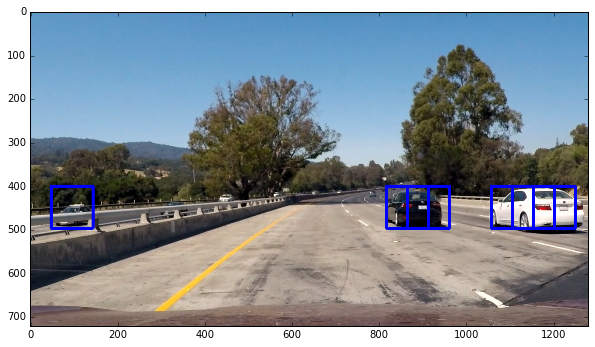

In [12]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/test_img_recs.jpg')
print('finished')

### Step3: Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
- draw all the potential search regions
The size and position of cars in the image will be different depending on their distance from the front-facing camera, thus `find_cars()` will be called several times with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  78


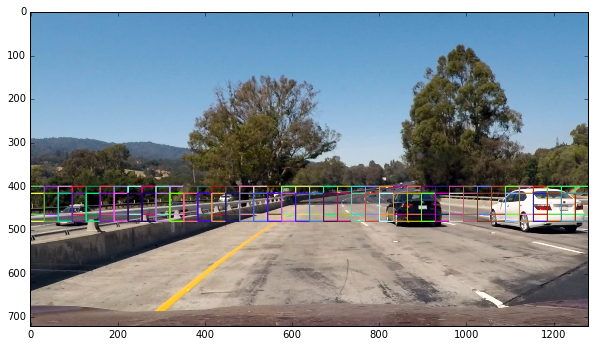

In [13]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/test_img_recs1.jpg')
print('Number of boxes: ', len(rectangles))

Tune the `ystart`, `ystop`, and `scale` values slightly as follows.

Number of boxes:  50


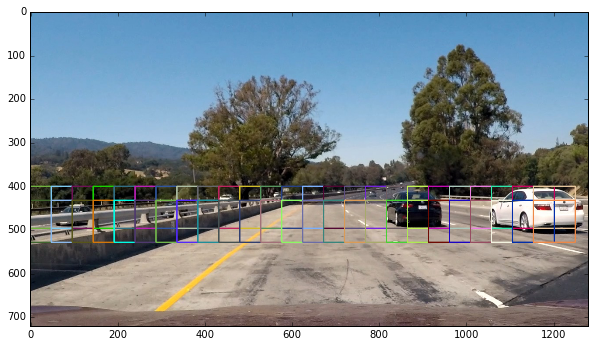

In [14]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/test_img_rects2.jpg')
print('Number of boxes: ', len(rectangles))

Tune the `ystart`, `ystop`, and `scale` values slightly again, as follows.

Number of boxes:  42


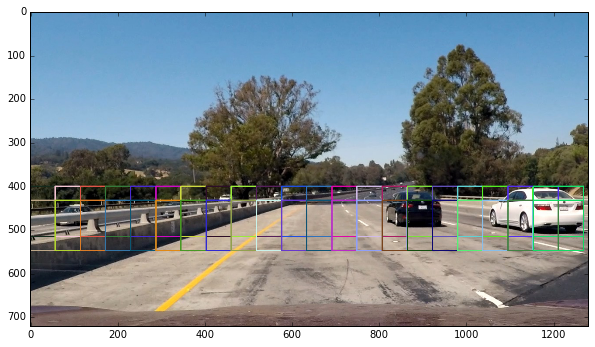

In [15]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 528
scale = 1.8
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 1.8
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/test_img_rects3.jpg')
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


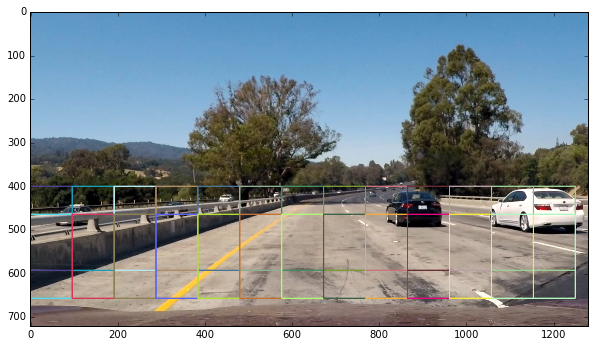

In [16]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/test_img_rects4.jpg')
print('Number of boxes: ', len(rectangles))

Combine all the sliding window search solutions.

finished


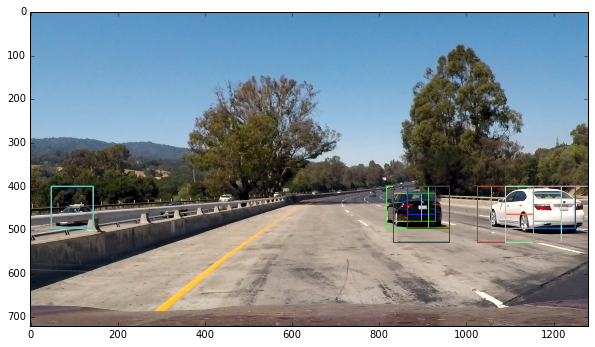

In [17]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/test_combined_rects.jpg')
print('finished')

#### My notes: It seems that the larger the scale is, the less windows are searched. And less false positive can be produced. Correspondingly, the start and stop coordinates are important, but not that important as scale factor.

### Step4: Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers(duplicate detections and false positives) and follow detected vehicles.
- create heat maps to reject duplicate detections and false positive.And the heatmap is based on the multiple detected rectangle locations.

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('finished')

finished


finished


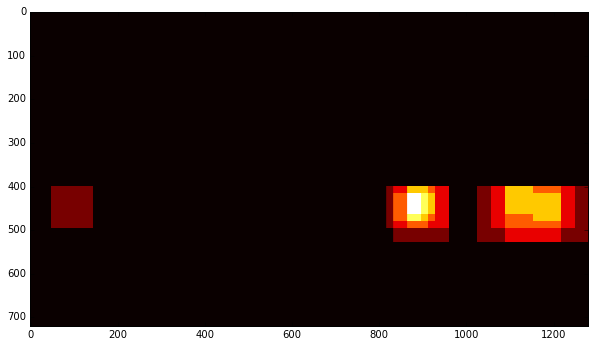

In [20]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.savefig('output_images/heatmap.jpg')

print('finished')

In [21]:
# apply a threshold to the heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('finished')

finished


finished


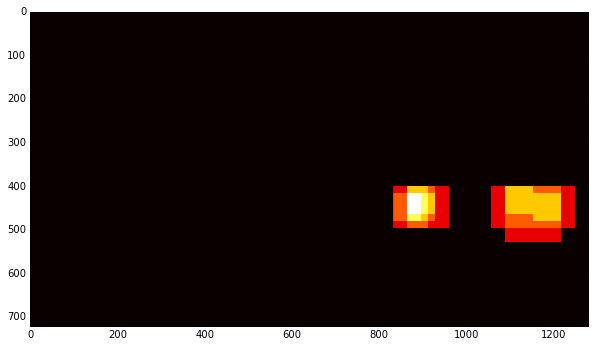

In [22]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.savefig('output_images/thresholded_heatmap.jpg')
print('finished')

2 cars found


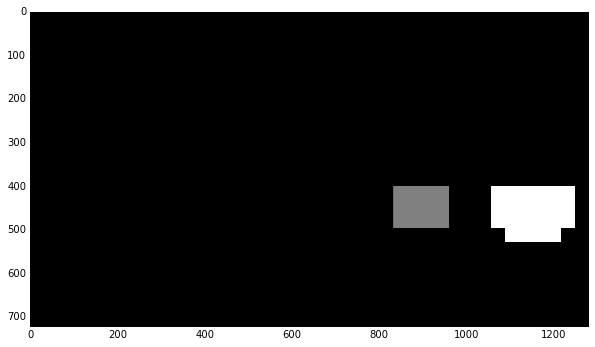

In [23]:
# implement SciPy labels to the heatmap
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.savefig('output_images/labeled_heatmap.jpg')
print(labels[1], 'cars found')

finished


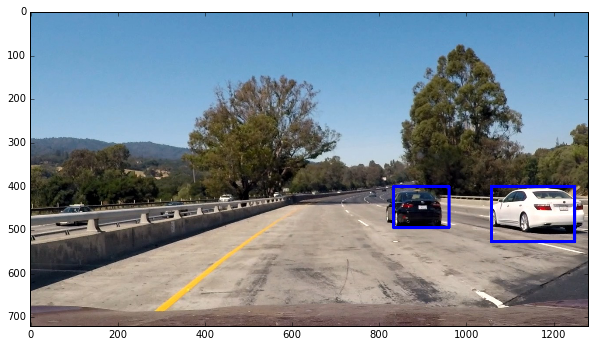

In [24]:
# draw the labeled bounding boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.savefig('output_images/draw_img.jpg')
print('finished')

### Step4: Run the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers(duplicate detections and false positives) and follow detected vehicles.
- run the pipeline on a video stream

In [25]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('finished')

finished


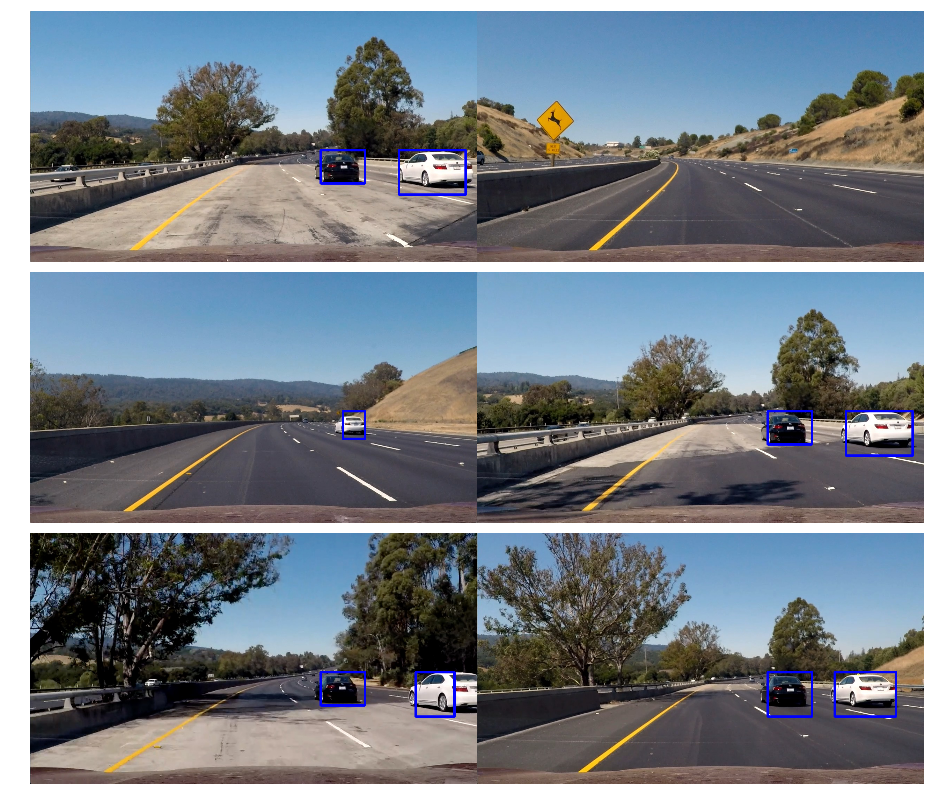

In [26]:
# run the pipeline on all the test images
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

fig.savefig('output_images/all_test_imgs.jpg')

### Step5: Estimate a bounding box for vehicles detected.
- define a class Vehicle_Detect() to estimate and store the bounding box information from detected vehicles.

Run a test video through the Pipeline, and the information from previous frames are considered.

In [31]:
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

print('finished')

finished


In [32]:
# pipeline on video processing
def video_processing(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('finished')

finished


In [33]:
det = Vehicle_Detect()

test_out_file = 'test_video_result.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(video_processing)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:11<00:00,  3.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

Wall time: 13 s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [35]:
det = Vehicle_Detect()

proj_out_file = 'project_video_result.mp4'
clip_proj = VideoFileClip('project_video.mp4') 
clip_proj_out = clip_proj.fl_image(video_processing)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:34<00:00,  3.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 6min 35s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))